<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/residuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Residuals Analysis

*Author: Alexander Del Toro Barba*

**What are residuals?**

For most time series models, the residuals are difference between observation and its corresponding estimated (fitted) value:

$e_{t} = y_{t} - \hat{y}_{t}$

**Why is it important to analyze residuals?**

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.

2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

Any forecasting method that does not satisfy these properties can be improved. However, that does not mean that forecasting methods that satisfy these properties cannot be improved. It is possible to have several different forecasting methods for the same data set, all of which satisfy these properties. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method.

If either of these properties is not satisfied, then the forecasting method can be modified to give better forecasts. Adjusting for bias is easy: if the residuals have mean m, then simply add m to all forecasts and the bias problem is solved. Fixing the correlation problem is harder, and we will not address it until Chapter 9.

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties.

3. The residuals have constant variance.

4. The residuals are normally distributed.

These two properties make the calculation of prediction intervals easier (see Section 3.5 for an example). However, a forecasting method that does not satisfy these properties cannot necessarily be improved. Sometimes applying a Box-Cox transformation may assist with these properties, but otherwise there is usually little that you can do to ensure that your residuals have constant variance and a normal distribution. Instead, an alternative approach to obtaining prediction intervals is necessary. Again, we will not address how to do this until later in the book.

# Import Libraries

In [0]:
# Import packages
import numpy as np
import sklearn
from decimal import *
from numpy import linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import collections
import datetime
import matplotlib
from scipy import stats
import scipy.stats as stats
import matplotlib.pylab as py
import matplotlib.pyplot as plt
from numpy import sqrt
from copy import copy
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import statsmodels
from statsmodels.tsa.stattools import adfuller
from numpy import log

# Create Data

**Random Walk Process**

In [0]:
def geometric_brownian_motion(T = 1, N = 100, mu = 0.1, sigma = 0.01, S0 = 20):        
    dt = float(T)/N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = N) 
    W = np.cumsum(W)*np.sqrt(dt) ### standard brownian motion ###
    X = (mu-0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) ### geometric brownian motion ###
    return S

dates = pd.date_range('2012-01-01', '2019-02-22')
T = (dates.max()-dates.min()).days / 365
N = dates.size
start_price = 100
randomwalk = pd.Series(
    geometric_brownian_motion(T, N, sigma=0.1, S0=start_price), index=dates)

**White Noise Process**

In [0]:
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot

# seed random number generator
seed(1)

# create white noise series
whitenoise = [gauss(0.0, 1.0) for i in range(3000)]
whitenoise = Series(whitenoise)

# Visualize Data

## Random Walk Process

Text(0, 0.5, 'Value')

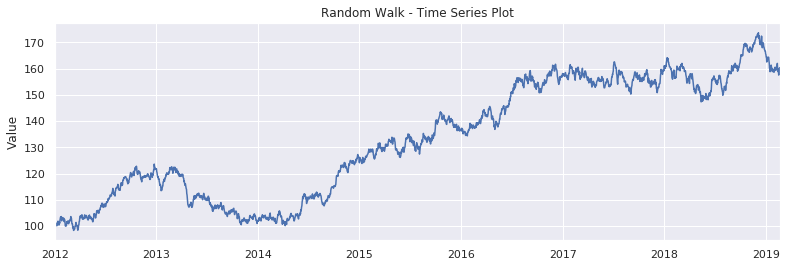

In [0]:
df = randomwalk
sns.set(rc={'figure.figsize':(13, 4)})
df.plot(linewidth=1.5,title='Random Walk - Time Series Plot')
plt.ylabel('Value')

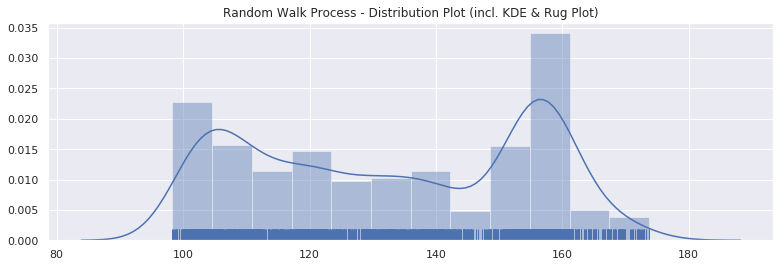

In [0]:
df = randomwalk
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((df), hist=True, rug=True).set_title('Random Walk Process - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

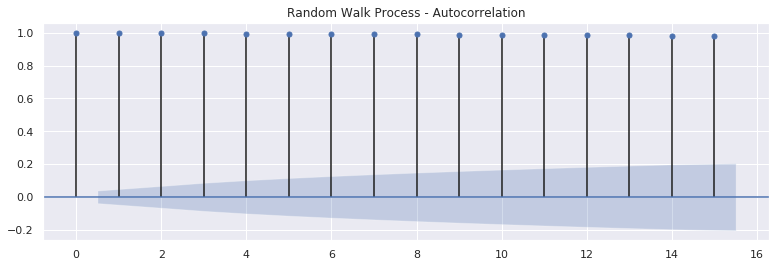

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sm.graphics.tsa.plot_acf(randomwalk.squeeze(), lags=15)
plt.title('Random Walk Process - Autocorrelation')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


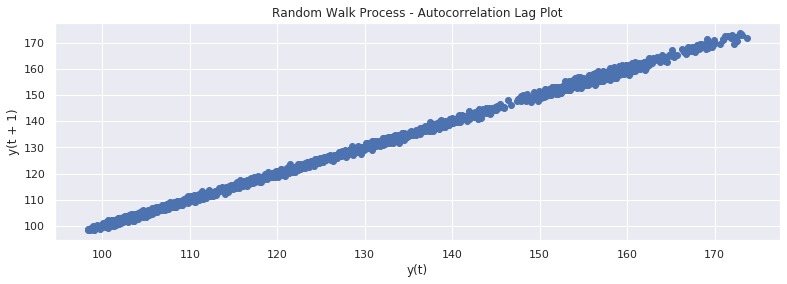

In [0]:
lag_plot(randomwalk)
plt.title('Random Walk Process - Autocorrelation Lag Plot')
plt.show()

## White Noise Process

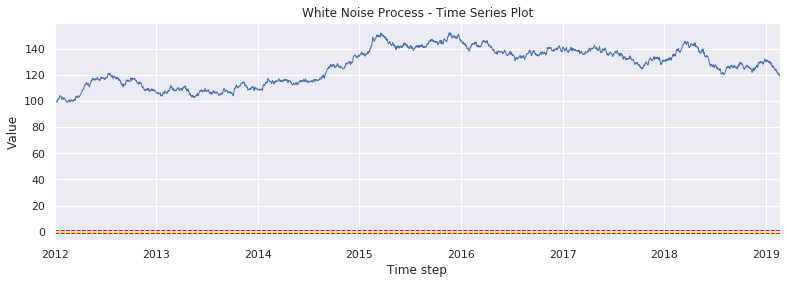

In [0]:
df = whitenoise
sns.set(rc={'figure.figsize':(13, 4)})
df.plot(linewidth=1.0,title='White Noise Process - Time Series Plot')
plt.ylabel('Value')
plt.xlabel('Time step')
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.0);
plt.axhline(y=-1, color='red', linestyle='--', linewidth=1.0);
plt.axhline(y=0, color='yellow', linestyle='--', linewidth=1.0);

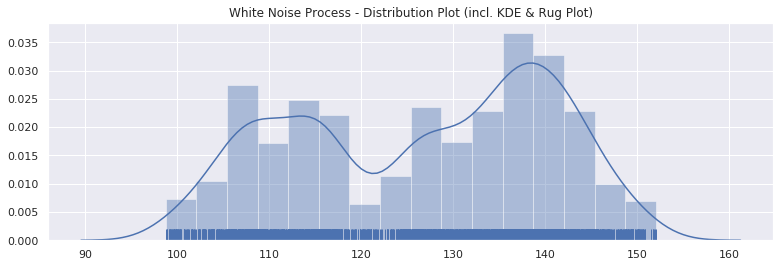

In [0]:
df = whitenoise
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((df), hist=True, rug=True).set_title('White Noise Process - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

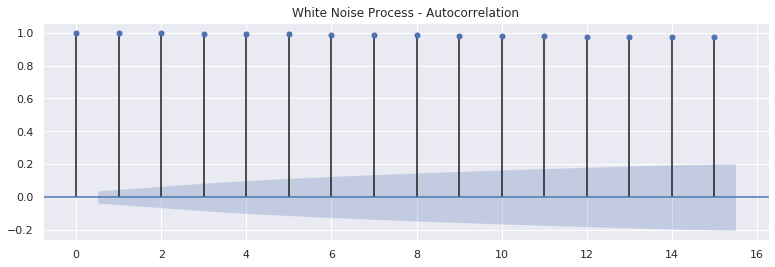

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sm.graphics.tsa.plot_acf(whitenoise.squeeze(), lags=15)
plt.title('White Noise Process - Autocorrelation')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


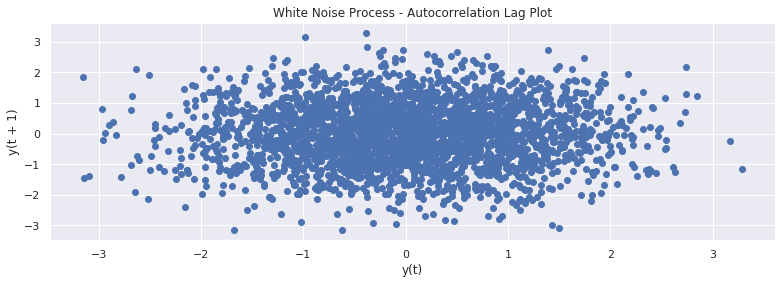

In [0]:
lag_plot(whitenoise)
plt.title('White Noise Process - Autocorrelation Lag Plot')
plt.show()

# Select Data Source

In [0]:
# series = whitenoise
series = randomwalk

# Residuals Analysis

## Percentage Differenced

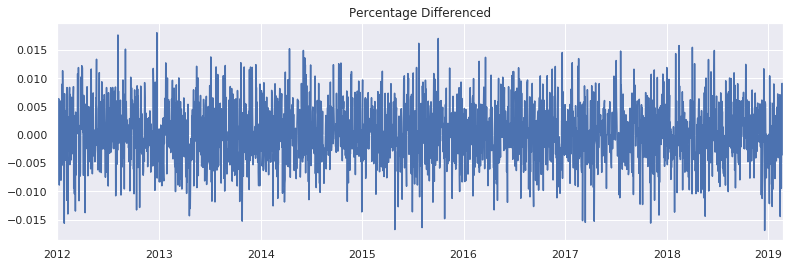

In [0]:
# Percentage Differenced
df = series / series.shift(1) -1
df.plot(title='Percentage Differenced')

## Differenced

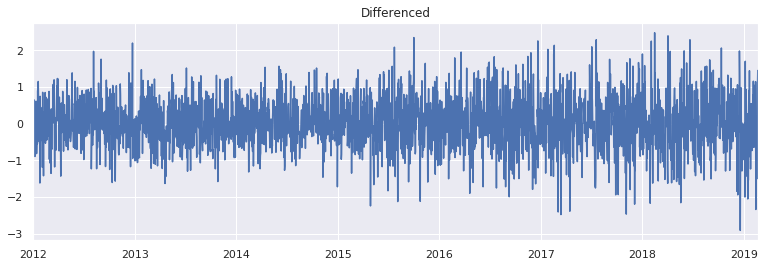

In [0]:
# Differenced
differenced = series - series.shift(1)
differenced.plot(title='Differenced')

## Square Root

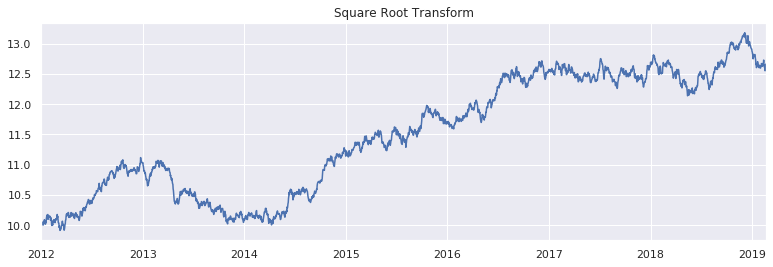

In [0]:
# Square Root Transform
sr = np.sqrt(series)
sr.plot(title='Square Root Transform')

## Log Return

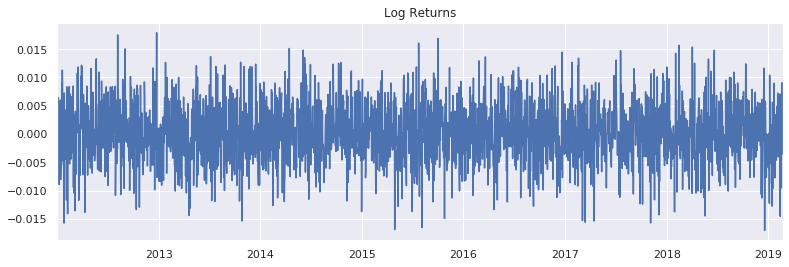

In [0]:
# Log Return
lr = np.log(series/series.shift(1)).dropna()
lr.plot(title='Log Returns')

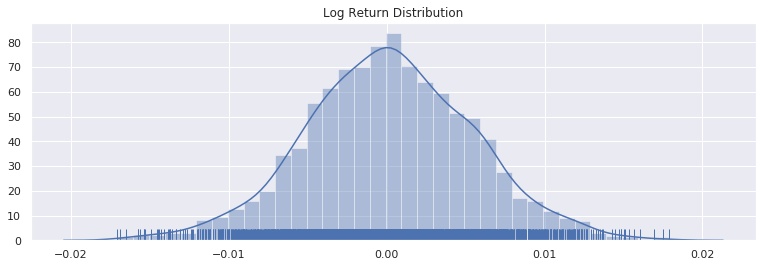

In [0]:
df = lr
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((df), hist=True, rug=True).set_title('Log Return Distribution')
plt.show()

## First Derivative

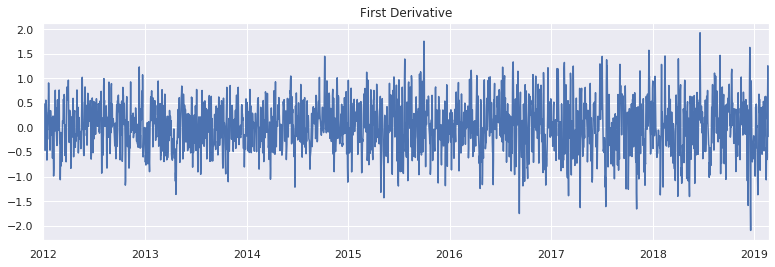

In [0]:
# First Derivative
fd = pd.Series(np.gradient(series), series.index, name='slope')
fd.plot(title='First Derivative')

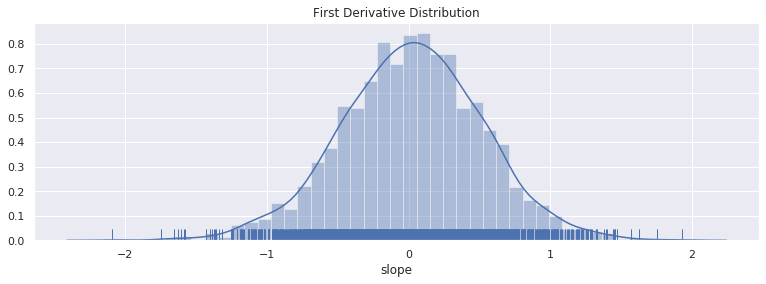

In [0]:
df = fd
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((df), hist=True, rug=True).set_title('First Derivative Distribution')
plt.show()